In [33]:
import pandas as pd

In [34]:
df = pd.read_csv("../data/interim/santander_limpio_filtrado_filas_y_data_engeniering.csv")

In [35]:
models_dir = '../models'

In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 319400 entries, 0 to 319399
Data columns (total 30 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   fecha_dato                319400 non-null  object 
 1   ncodpers                  319400 non-null  int64  
 2   sexo                      319400 non-null  object 
 3   age                       319400 non-null  int64  
 4   fecha_alta                319400 non-null  object 
 5   ind_nuevo                 319400 non-null  float64
 6   antiguedad                319400 non-null  int64  
 7   tiprel_1mes               319400 non-null  object 
 8   canal_entrada             319400 non-null  object 
 9   renta                     319400 non-null  float64
 10  segmento                  319400 non-null  object 
 11  cuenta_ahorros            319400 non-null  int64  
 12  cuenta_corriente          319400 non-null  int64  
 13  credito_rapido            319400 non-null  i

#### Con el dataset ya limpio, realizado el feature engineering, vamos a realizar:

- One-hot-encoding
- Normalización de los datos

- Antes de comenzar vamos a realizar unos cambios en el dataset que son importantes

In [37]:
df["fecha_dato"] = pd.to_datetime(df["fecha_dato"], errors="coerce")
df["fecha_alta"] = pd.to_datetime(df["fecha_alta"], errors="coerce")

print(f"NaNs en 'fecha_dato' después de conversión: {df['fecha_dato'].isnull().sum()}")
print(f"NaNs en 'fecha_alta' después de conversión: {df['fecha_alta'].isnull().sum()}")


NaNs en 'fecha_dato' después de conversión: 0
NaNs en 'fecha_alta' después de conversión: 0


In [38]:
product_cols = [
    'cuenta_ahorros', 'cuenta_corriente', 'credito_rapido', 'cuenta_nomina',
    'cuenta_joven', 'cuenta_adulto_mayor', 'cuenta_apertura', 'cuenta_pagos',
    'cuenta_debitos', 'deposito_largo_plazo', 'ecuenta', 'hipotecas',
    'ahorro_programado', 'prestamo_libre_inversion', 'tarjeta_credito',
    'credito_vivienda'
]

date_abr = pd.to_datetime('2016-04-28')
date_may = pd.to_datetime('2016-05-28')

df_abr = df[df['fecha_dato'] == date_abr].copy()
df_may = df[df['fecha_dato'] == date_may].copy()

In [39]:
df["fecha_dato"].unique()

<DatetimeArray>
['2016-03-28 00:00:00', '2016-04-28 00:00:00', '2016-05-28 00:00:00']
Length: 3, dtype: datetime64[ns]

In [40]:
common_customers = pd.merge(df_abr[['ncodpers']], df_may[['ncodpers']], on='ncodpers', how='inner')
df_abr = df_abr[df_abr['ncodpers'].isin(common_customers['ncodpers'])].sort_values('ncodpers').reset_index(drop=True)
df_may = df_may[df_may['ncodpers'].isin(common_customers['ncodpers'])].sort_values('ncodpers').reset_index(drop=True)

In [41]:
y = (df_may[product_cols] - df_abr[product_cols]).clip(lower=0)
X = df_abr.drop(columns=['fecha_dato', 'fecha_alta', 'ncodpers'] + product_cols)

print(f"\nShape de X (features de Abril): {X.shape}")
print(f"Shape de y (nuevos productos en Mayo): {y.shape}")
print("\nPrimeras 5 filas de y (nuevos productos):")
display(y.head())

ncodpers_train = df_abr['ncodpers']


Shape de X (features de Abril): (103158, 11)
Shape de y (nuevos productos en Mayo): (103158, 16)

Primeras 5 filas de y (nuevos productos):


,cuenta_ahorros,cuenta_corriente,credito_rapido,cuenta_nomina,cuenta_joven,cuenta_adulto_mayor,cuenta_apertura,cuenta_pagos,cuenta_debitos,deposito_largo_plazo,ecuenta,hipotecas,ahorro_programado,prestamo_libre_inversion,tarjeta_credito,credito_vivienda
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [42]:
X.shape

(103158, 11)

In [43]:
from sklearn.preprocessing import OneHotEncoder

categorical_cols_ohe = ['sexo', 'tiprel_1mes', 'canal_entrada', 'segmento']

ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

for col in categorical_cols_ohe:
    X[col] = X[col].astype(str)

X_encoded = ohe.fit_transform(X[categorical_cols_ohe])

In [44]:
X_encoded_df = pd.DataFrame(X_encoded, columns=ohe.get_feature_names_out(categorical_cols_ohe))


In [45]:
X_final = pd.concat([X.drop(columns=categorical_cols_ohe), X_encoded_df], axis=1)

print(f"\nShape de X después de One-Hot Encoding: {X_final.shape}")
print("Columnas de X después de One-Hot Encoding (primeras 5):")
display(X_final.head())


Shape de X después de One-Hot Encoding: (103158, 22)
Columnas de X después de One-Hot Encoding (primeras 5):


,age,ind_nuevo,antiguedad,renta,total_productos,tiene_ecuenta_y_tarjeta,antiguedad_por_edad,sexo_H,sexo_V,tiprel_1mes_A,...,tiprel_1mes_R,canal_entrada_KAT,canal_entrada_KFC,canal_entrada_KHE,canal_entrada_KHQ,canal_entrada_Otros,segmento_01 - TOP,segmento_02 - PARTICULARES,segmento_03 - UNIVERSITARIO,segmento_DESCONOCIDO
0,63,0.0,255,71461.20,2,1,0.337302,0.0,1.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,62,0.0,255,430477.41,3,1,0.342742,1.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,60,0.0,255,281757.72,2,1,0.354167,0.0,1.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,49,0.0,255,205427.58,2,1,0.433673,1.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,50,0.0,255,183021.75,1,0,0.425000,0.0,1.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [46]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
import lightgbm as lgb
import xgboost as xgb
from sklearn.metrics import roc_auc_score, f1_score
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from scipy.stats import uniform, randint
import pickle # ¡Ahora usamos pickle!
import os
import numpy as np
import warnings # Para suprimir advertencias de XGBoost si es necesario

In [47]:
X_train, X_val, y_train_all, y_val_all = train_test_split(X_final, y, test_size=0.2, random_state=42)

In [48]:
selected_product_cols = [
    'cuenta_corriente',
    'tarjeta_credito',
    'ecuenta',
    'cuenta_nomina',
    'deposito_largo_plazo'
]

In [53]:
import lightgbm as lgb
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import pickle

selected_product_cols = [
    'cuenta_corriente',
    'tarjeta_credito',
    'ecuenta',
    'cuenta_nomina',
    'deposito_largo_plazo'
]

results = {}

for target_col in selected_product_cols:
    print(f"\n📦 Entrenando modelos para: {target_col}")
    
    # Separar etiquetas para esta variable
    y_target = y[target_col]
    
    # Split
    X_train, X_val, y_train, y_val = train_test_split(
        X_final, y_target, test_size=0.2, random_state=42
    )

    # ---------------- LIGHTGBM ----------------
    print("🔷 LightGBM:")
    lgb_train = lgb.Dataset(X_train, label=y_train)
    lgb_val = lgb.Dataset(X_val, label=y_val)

    lgbm_model = lgb.train(
        params={
            'objective': 'regression',
            'metric': 'rmse',
            'verbosity': -1
        },
        train_set=lgb_train,
        valid_sets=[lgb_train, lgb_val],
        callbacks=[
            lgb.early_stopping(stopping_rounds=50),
            lgb.log_evaluation(period=100)
        ]
    )

    y_pred_lgb = lgbm_model.predict(X_val, num_iteration=lgbm_model.best_iteration)
    rmse_lgb = mean_squared_error(y_val, y_pred_lgb, squared=False)
    print(f"🔹 RMSE LightGBM: {rmse_lgb:.4f}")

    # ---------------- XGBOOST ----------------
    print("🔶 XGBoost:")
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dval = xgb.DMatrix(X_val, label=y_val)

    xgb_model = xgb.train(
        params={
            'objective': 'reg:squarederror',
            'eval_metric': 'rmse',
            'verbosity': 0
        },
        dtrain=dtrain,
        num_boost_round=1000,
        evals=[(dtrain, 'train'), (dval, 'eval')],
        early_stopping_rounds=50,
        verbose_eval=100
    )

    y_pred_xgb = xgb_model.predict(dval)
    rmse_xgb = mean_squared_error(y_val, y_pred_xgb, squared=False)
    print(f"🔸 RMSE XGBoost: {rmse_xgb:.4f}")

    # ---------------- SELECCIÓN Y GUARDADO ----------------
    if rmse_lgb < rmse_xgb:
        best_model = lgbm_model
        best_name = "LightGBM"
        best_rmse = rmse_lgb
        model_file = f"mejor_modelo_{target_col}_lightgbm.pkl"
        with open(model_file, "wb") as f:
            pickle.dump(best_model, f)
    else:
        best_model = xgb_model
        best_name = "XGBoost"
        best_rmse = rmse_xgb
        model_file = f"mejor_modelo_{target_col}_xgboost.pkl"
        with open(model_file, "wb") as f:
            pickle.dump(best_model, f)

    print(f"✅ Mejor modelo para {target_col}: {best_name} con RMSE = {best_rmse:.4f}")
    print(f"💾 Modelo guardado como: {model_file}")

    # Guardar resultados
    results[target_col] = {
        "LightGBM_RMSE": rmse_lgb,
        "XGBoost_RMSE": rmse_xgb,
        "Best_Model": best_name,
        "Best_RMSE": best_rmse
    }



📦 Entrenando modelos para: cuenta_corriente
🔷 LightGBM:
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[2]	training's rmse: 0.087939	valid_1's rmse: 0.0879907
🔹 RMSE LightGBM: 0.0880
🔶 XGBoost:
[0]	train-rmse:0.08775	eval-rmse:0.08803
[49]	train-rmse:0.08202	eval-rmse:0.08967
🔸 RMSE XGBoost: 0.0897
✅ Mejor modelo para cuenta_corriente: LightGBM con RMSE = 0.0880
💾 Modelo guardado como: mejor_modelo_cuenta_corriente_lightgbm.pkl

📦 Entrenando modelos para: tarjeta_credito
🔷 LightGBM:
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[16]	training's rmse: 0.13346	valid_1's rmse: 0.135061
🔹 RMSE LightGBM: 0.1351
🔶 XGBoost:
[0]	train-rmse:0.13450	eval-rmse:0.13521
[52]	train-rmse:0.12799	eval-rmse:0.13628
🔸 RMSE XGBoost: 0.1363
✅ Mejor modelo para tarjeta_credito: LightGBM con RMSE = 0.1351
💾 Modelo guardado como: mejor_modelo_tarjeta_credito_lightgbm.pkl

📦 Entrenando modelos para: ecuenta
🔷 Li

In [55]:
tabla_resultados = pd.DataFrame(results).T
print("\nTabla Resumen de Resultados:")
tabla_resultados


Tabla Resumen de Resultados:


,LightGBM_RMSE,XGBoost_RMSE,Best_Model,Best_RMSE
cuenta_corriente,0.087991,0.089687,LightGBM,0.087991
tarjeta_credito,0.135061,0.136336,LightGBM,0.135061
ecuenta,0.074265,0.075149,LightGBM,0.074265
cuenta_nomina,0.075703,0.076625,LightGBM,0.075703
deposito_largo_plazo,0.015568,0.016557,LightGBM,0.015568


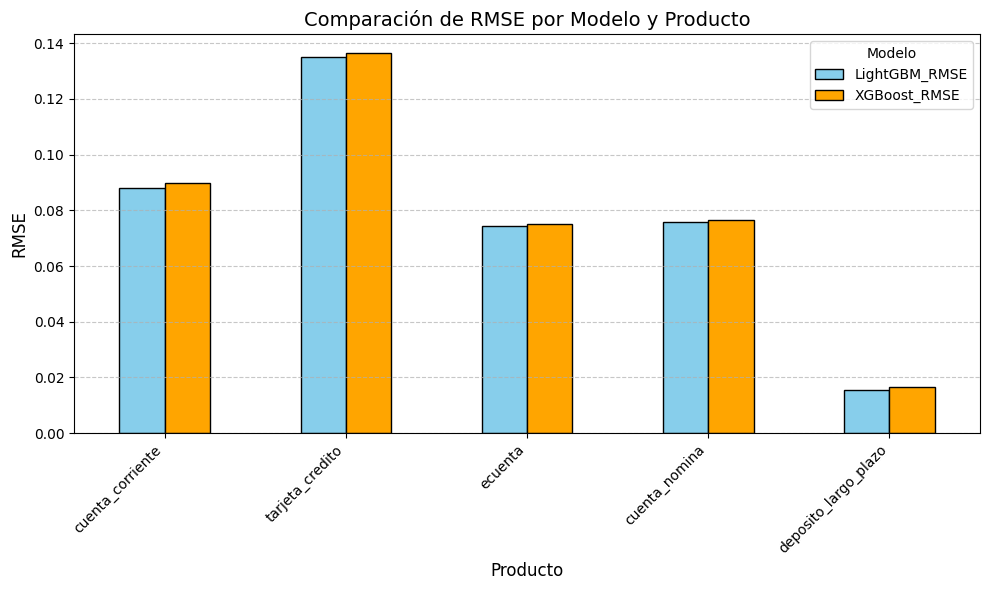

In [57]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 6))

tabla_resultados[['LightGBM_RMSE', 'XGBoost_RMSE']].plot(
    kind='bar',
    ax=ax,
    color=['skyblue', 'orange'],
    edgecolor='black'
)

plt.title('Comparación de RMSE por Modelo y Producto', fontsize=14)
plt.ylabel('RMSE', fontsize=12)
plt.xlabel('Producto', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.legend(title='Modelo')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

plt.show()